# 第五章 - 支持向量机 Support Vector Machines

支持向量机(SVM)是一种非常强大且通用的机器学习模型，其能够执行线性或非线性分类、回归，甚至是异常值检测等任务。它是机器学习中最流行的模型之一，任何对机器学习感兴趣的人都应该把它放在自己的工具箱里。支持向量机特别适合于对中小型复杂数据集进行分类。本章将解释支持向量机的核心概念，以及如何使用它们和它们是如何工作的。

## 0.Setup
先做一些基本的设定

In [2]:
# 本笔记要求　Python ≥3.5
# 导入一些必要的库，并要求版本
import sys
assert sys.version_info >= (3, 5)

# 本笔记要求　Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# 导入必要的包
import numpy as np
import os

# 确定随机种子，保证输出结果稳定
np.random.seed(42)

# 导入绘图工具，设置相关参数
# 使用rc配置文件来自定义图形的各种默认属性
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 在何处保存图片
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True) # 若exist_ok的值为False（默认），在相应文件夹已经存在的情况下会抛出OSError

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() # tight_layout()会自动调整子图布局，使子图充满图像。但是这是实验特性，在某些情况下会出现异常。
    plt.savefig(path, format=fig_extension, dpi=resolution) # 在相应地址存储图片，格式为png，分辨率为300*300

## 1.Linear SVM Classification（线性支持向量机分类）

本书将会使用一些图片来解释支持向量机背后的基本思想。图5-1显示了第4章末尾介绍的鸢尾花数据集的一部分内容。可以看到，图中的两个类别可以很容易地用直线分开(它们是线性可分离的)。

左边的图显示了线性分类器决策边界的三种可能。其中虚线所表示的决策边界的模型非常糟糕，其甚至不能正确的进行分类。而另外两个模型在这个训练集上工作得很好，但是它们的决策边界非常接近实例，这可能会影响模型的泛化性能。与之相对的，图中右侧实线表示SVM分类器的决策边界;这条线不仅很好地分隔了两个类，而且还尽可能地远离最近的训练实例，这是相当优秀的决策边界。

你可以将SVM分类器看作是在类之间拟合最宽的间隔(由右图中的平行虚线表示)，我们称其为最大间隔分类。

请注意，添加更多“远离间隔”的训练实例根本不会影响决策边界:决策边界完全由位于间隔边缘的实例确定(或“支持”)。这些实例称为支持向量(图5-1中被圈起来的实例)。

In [3]:
from sklearn.svm import SVC 
from sklearn import datasets

iris = datasets.load_iris() # 下载鸢尾花数据集
X = iris["data"][:, (2, 3)]  # 获取花瓣长和宽，作为数据
y = iris["target"] # 获取类别标签

# 以下三行代码的用处是取出两个类别的数据，坐着在这里选取的事类别为0或1的实例
setosa_or_versicolor = (y == 0) | (y == 1) # 如果标签为1或0时返回True，其他情况返回False
X = X[setosa_or_versicolor] # 取出对应的数据
y = y[setosa_or_versicolor] # 取出对应的标签

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf")) # SVC：使用支持向量机做分类，并且设置了部分参数
svm_clf.fit(X, y) # 输入响应的数据和标签，注意这里输入的数据仅仅是花瓣的长和宽

SVC(C=inf, kernel='linear')

Saving figure large_margin_classification_plot


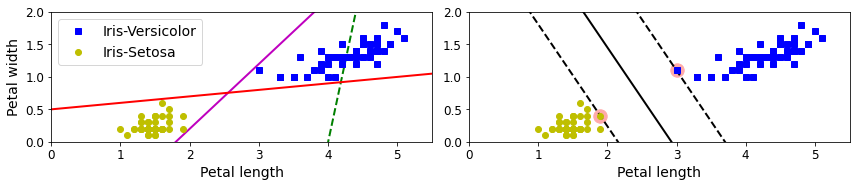

In [4]:
# Bad models
x0 = np.linspace(0, 5.5, 200) # 将0到5.5分成200份
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0] # coef_表示参数w
    b = svm_clf.intercept_[0] # intercept表示偏置b

    # 在决策边界上，有公式 w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1] # 计算间隔宽度
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin # 计算上下间隔位置 

    svs = svm_clf.support_vectors_ # 获取支持向量
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)

plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

图 5-1

支持向量机对特征尺寸很敏感，如图5-2所示:在左图中，垂直尺度远大于水平尺度，所以最宽的间隔接近水平。在进行特征缩放（例如，使用Scikit-Learn的StandardScaler）之后，决策边界看起来就好很多。

Saving figure sensitivity_to_feature_scales_plot


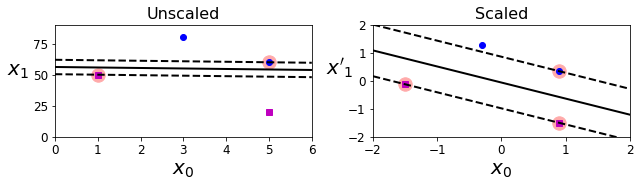

In [5]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs) # 进行特征缩放
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

图5-2

### 1.1软间隔分类

如果我们严格要求所有的实例都不在间隔内，而处于间隔两侧，则称之为硬间隔分类。

硬间隔分类主要有两个问题：首先，它只在数据是线性可分的情况下有效；其次，它对异常值非常敏感。

图5-3显示了鸢尾花数据集，只有一个额外的异常值:在左图,找不到一个合适的硬间隔；在右图中，决策边界与我们在图5-1中看到的没有异常值的情况完全不同，并且该分类器在新数据上的泛化性能不会很好。

Saving figure sensitivity_to_outliers_plot


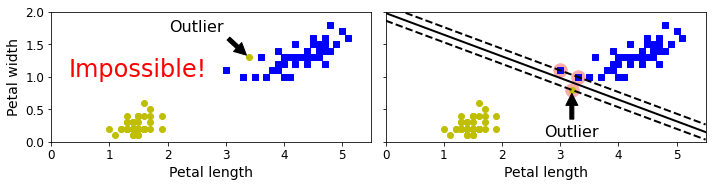

In [6]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

图5-3

为了避免这些问题，最好使用更灵活的模型。目标是在保持间隔尽可能大与限制错误分类之间找到一个良好的平衡。例如分类后的实例可能会出现在间隔中间甚至是错误的分类一侧，这就是所谓的软间隔分类。

在Scikit-Learn的SVM类中，你可以使用C超参数控制这种平衡:较小的C值会导致更宽的间隔，但会有更多的错误分类。图5-4显示了两个软间隔SVM分类器在非线性可分数据集上的决策边界和间隔。在左图中，使用一个较低的C值，间隔会相当大，但很多实例会出现在间隔中。在右侧，使用较高的C值，分类器的错误分类很少，但最终得到的间隔更小。

看起来第一个分类器有更好的泛化性能，因为大多数间隔违例都处于决策边界正确的一边，所以即使是在该训练集上，它所做出的错误预测也更少。

如果你的支持向量机模型过拟合了，可以尝试调低超参数Ｃ。

下面的Scikit-Learn代码加载鸢尾花数据集，进行缩放特征，然后训练一个线性SVM模型(使用C = 1的LinearSVC类和合页(hinnge)损失函数，稍后会介绍)来检测Iris-Virginica花。最终的结果显示在5-4的右侧。

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

用以上训练好的模型进行预测

In [8]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

下面的代码对不同正则化参数进行比较。

In [9]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [10]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


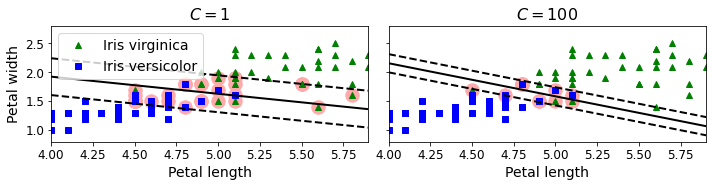

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

图5-4

与logistic回归分类器不同，SVM分类器不输出每个类的概率。当然，你也可以有更多选择：
+ 你可以使用SVC类，使用SVC（kernel =“linear”，C = 1），但速度要慢得多，特别是对于大型训练集，因此不推荐使用。
+ 另一种选择是使用SGDClassifier类，使用SGDClassifier（loss =“hinge”，alpha = 1 /（m * C））。这适用于规则的随机梯度下降（见第4章）来训练线性SVM分类器。它不像LinearSVC类那样快速收敛，但它可以用于处理不适合内存（核外训练）的大型数据集，或处理在线分类任务。

LinearSVC类会正则化偏置(bias),所以在使用时应该先首先通过减去其平均值来使训练集居中。如果使用StandardScaler缩放数据，则会自动执行此操作。此外，请确保将损失超参数设置为“hinge”，因为它不是默认值。最后，为了获得更好的性能，您应该将双超参数设置为False，除非特征数比训练实例多（我们将在本章后面讨论二元性）。

## 2.非线性支持向量机分类

尽管线性SVM分类器在多数情况下是有效的，并且有着非常好的效果，但许多数据集不是线性可分的。处理非线性数据集的一种方法是添加更多的特征，如多项式特征(见第四章);在某些情况下，这样操作会使数据集线性可分。

考虑图5-5中左边的图:它表示只有一个特征x1的简单数据集。这个数据集不是线性可分的。但是如果你加入一个二次特征$x_2 =(x_1)^2$，得到的2D数据集是完全线性可分的。

Saving figure higher_dimensions_plot


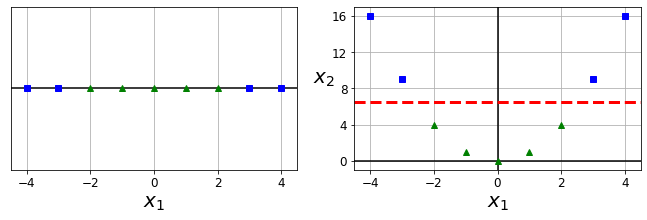

In [12]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

图5-5

要使用Scikit-Learn实现这个想法，你可以创建包含PolynomialFeatures变换器的程序（在第121页的“多项式回归”中讨论的），然后是StandardScaler和LinearSVC。 让我们在moons dataset 上测试一下（见图5-6）：

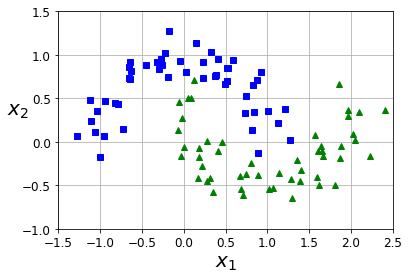

In [13]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [14]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

Saving figure moons_polynomial_svc_plot


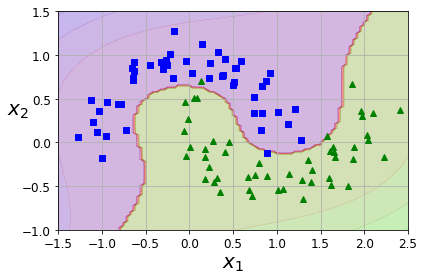

In [15]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

图5-6

### 2.1 多项式核函数

添加多项式特征这一操作实现起来比较简单,可以用于各种各样的机器学习算法(不仅仅是支持向量机),但在低阶多项式不能处理非常复杂的数据集；而高阶多项式会产生大量的特征，拖累模型的速度。

幸运的是，在使用支持向量机时，你可以使用一种奇迹般的数学技巧，我们称之为核技巧(稍后将对此进行解释)。核技巧可以获得与添加许多多项式特征相同的结果，即是该结果需要添加非常高阶的多项式，使用核技巧也能获得同样的结果。因此，由于我们实际上并没有添加任何特征，因此就可以避免特征之间的组合爆炸。该技巧由SVC类实现。我们可以在moons数据集上去测试它的性能。

In [16]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

上面的代码使用３阶多项式内核训练SVM分类器，相关的内容在图5-7的左图中显示。而右图是使用10阶多项式内核的SVM分类器。显然，如果模型过拟合，你可能希望降低多项式次数。如果模型欠拟合，你可以尝试增加多项式次数。

超参数coef0控制模型受高阶多项式与低阶多项式的影响程度。

In [17]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

Saving figure moons_kernelized_polynomial_svc_plot


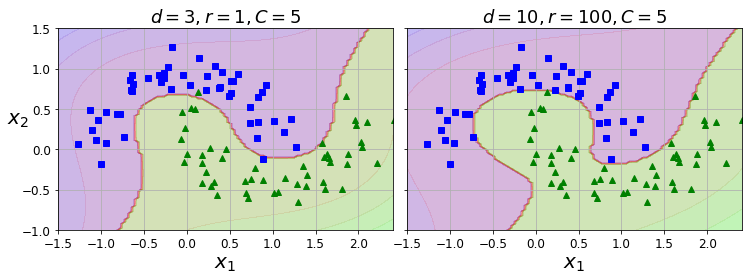

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

图5-7

找到正确超参数值的一种常用方法是使用网格搜索(见第2章)。首先做一个非常粗糙的网格搜索，然后根据找到的最佳值进行更精细的网格搜索，这种做法通常会获得更快的速度。

充分了解每个超参数的实际作用可以更有效的在超参数空间中进行搜索。

### 2.2 添加相似特征

解决非线性问题的另一种技术就是添加相似特征。这些特征可以通过计算相似函数得出，相似函数可以测量每个实例与一个特定地标之间的相似度。以前面提到的一维数据集为例，在 $x_1 = -2$ 和 $x_1 = 1$ 处为其添加两个地标（参见图5-8中的左图）。然后使用高斯径向基函数(RBF)作为相似函数，y=0.3。（见公式5-1）

$\phi_{\gamma}(\mathbf{x}, \ell)=\exp \left(-\gamma\ || \mathbf{x}-\ell\ || ^{2}\right)$ 式5-1

它是一个钟形函数，从0（距地标很远）到1（在地标处）不等。现在我们已准备好计算新特征。例如，让我们看一下实例**$x_1 = -1$** ：它位于距第一个地标距离为**1**的地方，距第二个地标距离为 **2**。因此，其新特征是 $x_2 = exp（-0.3×1^2）≈0.74$ 并且 $x_3 = exp（-0.3×2^2）≈0.30$。
图5-8右侧的图显示了转换后的数据集（删除原始特征）。如您所见，它现在可以线性分离了。


Saving figure kernel_method_plot


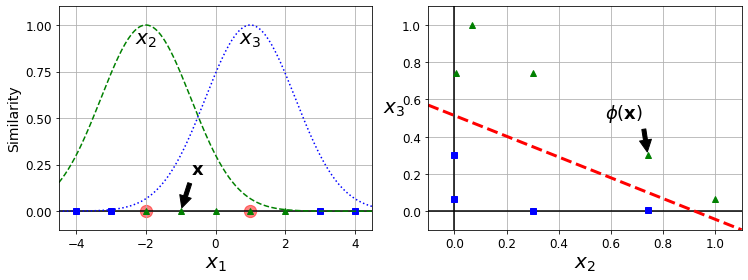

In [19]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

图5-8

那我们如何选择地标呢？最简单的方法是在数据集中每个实例的位置创建一个地标。这样就创建了许多维度，从而就增加了训练集可分离的可能性。缺点就是具有m个实例和n个特征的训练集被转换成就有m个实例和m个特征的训练集（假设你删除了原始特征）。如果你的训练集十分庞大，那么就会获得同样大数量的特征。

### 2.3 高斯径向基核函数

与多项式特征方法一样，相似特征法也可以用于任何机器学习算法，但计算所有的附加特征可能导致很高的计算成本，特别是在大型数据集上。然而，核技巧再一次施展了SVM魔术：它可以在不添加许多相似特征的前提下达到添加相似特征的性能。让我们来使用SVC类来尝试一下高斯径向基核：

In [20]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

图5-9的左下方显示了这个模型。其他图显示了使用不同超参数值gammay()和C训练的模型。增加gamma值会使钟形曲线变窄(如5-8左图所示)，因此每个实例的影响范围都随之变小：决策边界变得更不规则，开始围着单个实例绕弯。反过来，减小gamma值使得钟型函数变得更宽，因此实例就具有更大的影响范围，决策边界也就变得更加平滑。
所以γ就像一个正则化超参数：如果你的模型过拟合，你应该减少它，如果它是欠拟合，你应该增加它（类似于C超参数）。

Saving figure moons_rbf_svc_plot


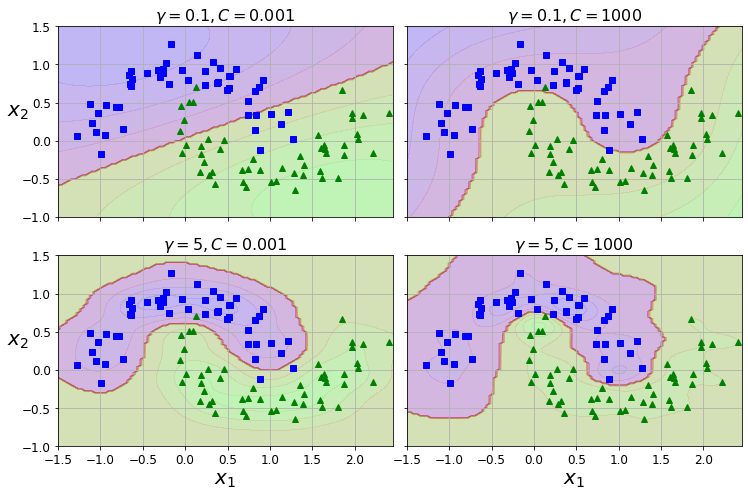

In [21]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

除了我们上面提到的多项式内核和高斯RBF内核，还存在其他内核但很少使用。例如，某些内核专门用于特定的数据结构。
在分类文本文档或DNA序列时，有时会使用字符串内核（例如，使用字符串子序列内核或基于Levenshtein距离的内核）。

在实际应用中我们有多种内核可以去选择，我们如何决定使用哪一个？
你应该首先尝试线性内核（请记住，LinearSVC比SVC(内核=“线性”)快得多），特别是如果训练集非常大或者它有很多特征。 如果训练集不是太大，你应该试试高斯RBF内核也是如此; 它在大多数情况下效果很好。
然后，如果你有空闲时间和计算能力，您还可以使用交叉验证和网格搜索来尝试其他一些内核，特别是如果有专门针对您的训练集的数据结构的内核。

### 2.4 计算复杂性

LinearSVC类基于liblinear库，其为线性SVM实现了一个优化算法。该算法不支持核技巧，不过它与训练实例的数量和特征数量几乎呈线性相关:其训练时间复杂度大致为O(m×n)。

如果你想得到非常高的精度，该算法需要更长的时间。这由容差超参数$ε$（在Scikit-Learn中称为tol）控制。在大多数分类任务中，默认容差就够了。

SVC类基于libsvm库，该库实现了支持内核技巧的算法。训练时间复杂度通常在$ O（m_2×n）$和 $O（m_3×n）$之间。不幸的是，这意味着当训练实例的数量变大（例如，数十万个实例）时，它变得非常慢。该算法适用于复杂但小型或中型训练集。但是，它随着特征的数量很好地扩展，特别是对于稀疏特征（即，当每个实例具有很多的零特征时）。在这种情况下，算法大致按每个实例的非零特征的平均数量进行缩放。

表5-1比较了Scikit-Learn的SVM分类类。


表格5-1

![image-20200731163825431](https://cdn.jsdelivr.net/gh/chenhaishun/test_pic@master/typora202007/31/163826-947714.png)


## 3.SVM回归

正如我们前面提到的一样，SVM算法十分通用：它不仅支持线性和非线性分类，还支持线性与非线性回归。其中的关键点是转换目标：SVM回归不是拟合两个分类之间的最宽间隔的同时限制间隔违例，其要做的是让尽可能多的实例位于间隔之间，同时限制间隔违例（不在间隔间的实例）。间隔的宽度由超参数$ε$控制。图5-10显示了在一些随机线性数据上训练的两个线性SVM回归模型，一个具有较大的宽度$（ε= 1.5）$，另一个具有较小的宽度$（ε= 0.5）$。

在间隔内添加更多训练实例不会影响模型预测; 因此，该模型被认为是$ε-不敏感( ϵ -insensitive.)$。

您可以使用Scikit-Learn的LinearSVR类来执行**线性SVM回归**。以下代码生成图5-10左侧所示的模型（训练数据应先缩放并居中）：

In [22]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [23]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [24]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Saving figure svm_regression_plot


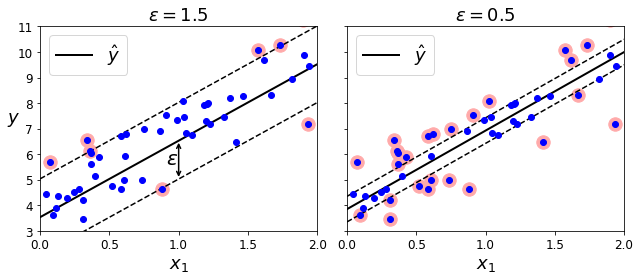

In [25]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

图5-10

要处理非线性回归任务，可以使用核化的SVM模型。例如，图5-11显示了在一个随机二次训练集上，使用二阶多项式核的SVM回归。左图几乎没有正则化（Ｃ值很大），右图则是过度正则化（Ｃ值很小）。

以下代码使用Scikit-Learn的SVR类（支持内核技巧）生成图5-11左侧所示的模型。 SVR类与SVC类回归等价，LinearSVR类也与LinearSVC类的回归等价。 LinearSVR类与训练集的大小成线性比例（就像LinearSVC类一样），而当训练集变大时SVR类变得太慢（就像SVC类一样）。SVM也可用于异常值检测; 有关详细信息，请参阅Scikit-Learn的文档。

In [26]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [27]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [28]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

Saving figure svm_with_polynomial_kernel_plot


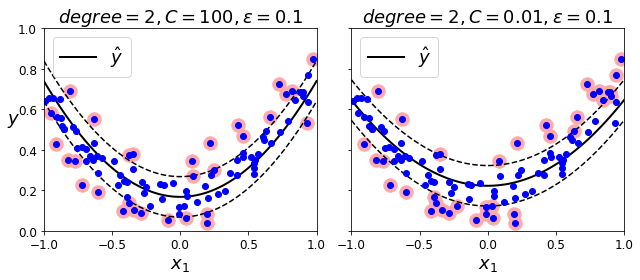

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

图5-11

## 4.工作原理

本节从线性支持向量机分类器开始，解释支持向量机是如何进行预测的，以及它们的训练算法是如何工作的。如果你刚刚开始机器学习，你可以跳过它，直接去看本章末尾的练习，然后当你想更深入地理解支持向量机时再回来学习。

首先，关于符号：
在第4章中，我们使用了将所有模型参数放在一个向量 $θ$ 中的惯例，包括偏置项 $θ_0 $ 和输入特征权重 $θ_1$ 到 $ θ_n $，并向所有实例添加偏置输入 $ x_0 = 1 $。
在本章中，我们将使用不同的约定，在处理SVM时更方便（也更常见）：偏置项将被称为 $ b $，而特征权重向量将被称为 $w$。在输入特征向量中不会添加偏差特征。

### 4.1 决策函数与预测
线性SVM分类器模型通过简单地计算**决策函数** $ w^T·x + b = w_1 x_1 + ... + w_nx_n + b $ 来预测新实例 $x$ 的类：如果结果为正，则预测类 $ŷ$ 为正 类(1)，否则是负类(0); 见公式5-2。

$\hat{y}=\left\{\begin{array}{l}0 \text { if } \mathbf{w}^{T} \mathbf{x}+b<0 \\ 1 \text { if } \mathbf{w}^{T} \mathbf{x}+b \geq 0\end{array}\right.$      公式５－２

图5-12显示了与图5-4右侧模型相对应的决策函数：因为该数据集有两个特征（花瓣宽度和花瓣长度），所以它是一个二维平面。决策边界是决策函数等于0的点集：它是两个平面的交点，它是一条直线（由粗实线表示）。


In [30]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

Saving figure iris_3D_plot


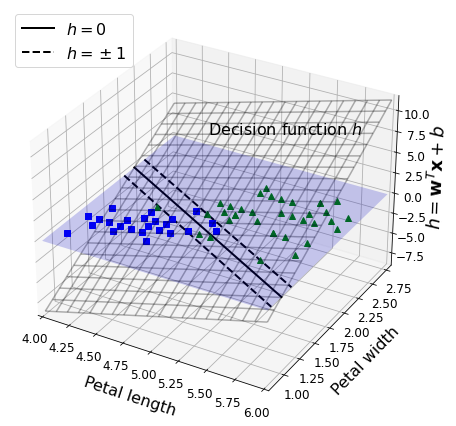

In [31]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

图5-12

虚线表示决策函数等于1或-1的点:它们与决策边界平行且距离相等，从而形成了一个间隔。训练一个线性SVM分类器意味着找到w和b的值，使这个边界尽可能宽，同时避免边界违规(硬边界)或限制边界(软边界)

## 5. 训练目标

让我们来思考一下决策函数的斜率，它等于权重向量的范数，即$ ||w|| $。如果我们将斜率除以２，那么决策函数等于±1的点将远离决策边界两倍。换句话说，将斜率除以2将使边距乘以2。也许这在图5-13(即下面代码所绘制的图)中的2D图中更容易可视化。 权重向量 w 越小，间隔越大。

Saving figure small_w_large_margin_plot


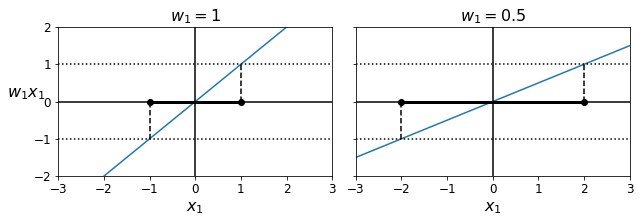

In [32]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

图5-13 权重越小，间隔越大

所以我们要最小化$ ||w|| $来得到尽可能大的间隔。但是，如果我们想避免任何间隔违例（硬间隔），那么就要使所有正类训练集的决策函数大于１，负类训练集的决策函数小于-1,
如果我们为负实例定义 $t^{(i)}= -1$(如果$ y^(i)= 0$)并且对于正实例定义$t^{(i)}= 1$（如果$ y^(i)= 1$），那么对于所有实例我们可以将这个约束表达为$t^{(i)}(w ^T·x^{(i)}+ b)≥1$。因此，我们可以将**硬间隔线性SVM分类器的目标**表达为公式5-3中的约束优化问题：

\begin{aligned}
&\operatorname{minimize}_{\mathbf{w}, b} \frac{1}{2} \mathbf{w}^{T} \mathbf{w}\\
&\text { subject to } \quad t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right) \geq 1 \quad \text { for } i=1,2, \cdots, m
\end{aligned}

式5-3

我们正在最小化$\frac{1}{2} w^T·w$，等价于 $\frac{1}{2}||w||^2$，而不是最小化$||w||$。这是因为它会给出相同的结果
（因为最小化一个值的 $w$ 和 $b$ 的值同时也最小化其平方的一半），但是$\frac{1}{2}||w||^2$有一个很好的简单的导数（它只是 $w$），而$||w||$在 $w = 0$ 时不可微分 优化算法在可微函数上运行得更好。

为了得软间隔分类的目标，我们需要为每个实例引入一个松弛变量$ζ^{(i)}≥ 0$：$ζ^{(i)}$ 测量允许第i个实例违反边界的程度。我们现在有两个相互矛盾的目标：使松弛变量尽可能小以减少边际违规（误分类），并使$\frac{1}{2} w^T·w$尽可能小以增加间隔。
这就是超参数C的用武之地：它允许我们定义这两个目标之间的权衡。这给出了我们公式5-4中的约束优化问题

\begin{aligned}
&\underset{\mathbf{w}, b, \zeta}{\operatorname{minimize}} \quad \frac{1}{2} \mathbf{w}^{T} \mathbf{w}+C \sum_{i=1}^{m} \zeta^{(i)}\\
&\text { subject to } \quad t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right) \geq 1-\zeta^{(i)} \text { and } \zeta^{(i)} \geq 0 \quad \text { for } i=1,2, \cdots, m
\end{aligned}   式 5-4



### 5.1 二次规划

硬间隔和软间隔问题都是线性约束的凸二次优化问题。这些问题被称之为二次规划（QP）问题。要求解二次规划问题有很多现成的求解器，使用到的技术各不相同，这些不在本书的讨论范围之内。公式5-5给出了问题的一般形式。

$\begin{array}{ll}\text { Minimize } & \frac{1}{2} \mathbf{p}^{T} \mathbf{H} \mathbf{p}+\mathbf{f}^{T} \mathbf{p}\end{array}$
subject to $\quad$ Ap $\leq$ b Where $\left\{\begin{array}{ll}\mathbf{p} & \text { is an } n_{p} \text { -dimensional vector }\left(n_{p}=\right.\text { number of parameters) } \\ \mathbf{H} & \text { is an } n_{p} \times n_{p} \text { matrix, } \\ \mathbf{f} & \text { is an } n_{p} \text { -dimensional vector, } \\ \mathbf{A} & \text { is an } n_{c} \times n_{p} \text { matrix }\left(n_{c}=\right.\text { number of constraints) } \\ \mathbf{b} & \text { is an } n_{c} \text { -dimensional vector. }\end{array}\right.$
 公式5-5

注意，表达式$ A·p ≤ b$实际上定义了$n_c$个约束：对于$i = 1,2，⋯，n_c$，$p^T·a^{(i)}≤b^{(i)}$，其中$a^{(i)}$是包含$A$第 $i$ 行元素的向量, $b（i） $是 $b $的第 $i$ 个元素。

您可以轻松验证如果以下列方式设置**QP**参数，得到硬间隔线性SVM分类器目标：
* $n_p = n+1$, n 是特征数量，**+1** 这一项是偏差项
* $n_c = m$，m 是训练实例的数量
* $H$ 是$n_p×n_p$是单位矩阵，除了在左上角的一项为零（忽略偏差项）。
* $f = 0$ ,一个$n_p$ 维的向量，元素都为0
* $b = 1$ ,一个$n_c$ 维的向量，元素都为1 
* $\mathbf{a}^{(i)}=-t^{(i)} \dot{\mathbf{x}}^{(i)},$ 其中 $\dot{\mathbf{x}}^{(i)}$ 等于 $\mathbf{x}^{(i)}$ 除了一个额外的偏置特征 $\dot{\mathbf{x}}_{0}=1$
 

所以，要训练硬间隔线性SVM分类器，其中一种方法是直接将上面的参数用在一个现成的二次规划求解器上。得到的向量$p$将包含偏置项$b = p_0$，并且对于$i = 1,2，...，m$，特征权重$w_i = p_i$。同样，您可以使用QP求解器来解决软间隔问题（参见本章末尾的练习）。

然而，为了使用核技巧，我们将研究一个不同的约束优化问题。

### 5.2 对偶问题

给定一个约束优化问题，称为原始问题，有可能表达一个不同但密切相关的问题，称其为对偶问题。对偶问题的解决方案通常给出原始问题的解决方案的下限，但在某些条件下它甚至可以具有与原始问题相同的解决方案。幸运的是，SVM问题碰巧满足这些条件，因此您可以选择解决原始问题或对偶问题;两者都有相同的解决方案。 公式5-6显示了线性SVM目标的对偶形式（如果您有兴趣知道如何从原始问题中导出对偶问题，请参阅附录C）。

$\operatorname{minimize}_{\alpha} \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i)^{T} \mathbf{x}^{(j)}}-\sum_{i=1}^{m} \alpha^{(i)}$
subject to $\alpha^{(i)} \geq 0$ for $i=1,2, \cdots, m$
公式５－６

一旦得到使该等式最小化（使用二次规划求解器）的向量$\hat{\alpha}$,就可以使用公式5-7来计算是原始问题最小化的$\hat{ w}$和$\hat{\ b}$

\begin{aligned}
\widehat{\mathbf{w}} &=\sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
\hat{b}=\frac{1}{n_{s}} & \sum_{i=1}^{m}\left(t^{(i)}-\widehat{\mathbf{w}}^{T} \mathbf{x}^{(i)}\right)
\end{aligned}
其中，第二个式子有条件为$\hat{\alpha}^{(i)}>0$                                    
公式5-7

当训练实例的数量小于特征的数量时，对偶问题比原始问题解决得更快。更重要的是，它使核技巧成为可能，而原始问题不可以。那么这个核技巧究竟是什么呢？

### 5.3 核化SVM

假设你要将二维多项式变换应用于二维训练集（例如moons train set ），然后在变换的训练集上训练线性SVM分类器。公式5-8显示了要应用的第二个多项式映射函数:

$\phi(\mathbf{x})=\phi\left(\left(\begin{array}{c}x_{1} \\ x_{2}\end{array}\right)\right)=\left(\begin{array}{c}x_{1}^{2} \\ \sqrt{2} x_{1} x_{2} \\ x_{2}^{2}\end{array}\right)$ 公式5-8

注意，变换后的矢量是三维的而不是二维的。现在让我们来看看如果我们应用这个二次多项式映射，然后计算变换向量的点积（见公式5-9）。几个二维向量a和b会发生什么。
![image-20200731163924185](https://cdn.jsdelivr.net/gh/chenhaishun/test_pic@master/typora202007/31/163925-618010.png)  公式5-9

变换矢量的点积等于原始矢量的点积的平方：$φ(a)^T·φ(b)=(a^T·b)^2$。

注意一下关键点：如果将变换$φ$应用于所有训练实例，那么对偶问题（见公式5-6）将包含点积$φ(x^{(i)})^T·φ(x^{(j)})$。但如果$φ$是公式5-8中定义的第二个多项式变换，然后你可以简单地用$(x^{{(i)}^T}·x^{(j)})^2$取代转换矢量的这个点积。所以你根本不需要转换训练实例：
只需用公式5-6中的平方替换点积。 结果将与您实际转换训练集然后拟合线性SVM算法的问题完全相同，但这个技巧使整个过程在计算上更有效率。 这是核技巧的本质。函数$K(a，b) =(a^T·b)^2$被称为二次多项式内核。在机器学习中，内核是能够仅基于原始矢量a和b计算点积$φ(a)^T·φ(b)$的函数，而不必计算（或甚至知道）变换$φ$。 公式5-10列出了一些最常用的内核：

$\begin{aligned} \text { Linear: } & K(\mathbf{a}, \mathbf{b})=\mathbf{a}^{T} \mathbf{b} \\ \text { Polynomial: } & K(\mathbf{a}, \mathbf{b})=\left(\gamma \mathbf{a}^{T} \mathbf{b}+r\right)^{d} \\ \text { Gaussian } \mathrm{RBF}: & K(\mathbf{a}, \mathbf{b})=\exp \left(-\gamma\|\mathbf{a}-\mathbf{b}\|^{2}\right) \\ \text { Sigmoid: } & K(\mathbf{a}, \mathbf{b})=\tanh \left(\gamma \mathbf{a}^{T} \mathbf{b}+r\right) \end{aligned}$ 公式5-10

### Mercer定理
根据Mercer定理，如果函数$K（a，b）$符合几个数学条件————也就是Mercer条件（Ｋ必须是连续的，并且参数对称，所以$K（a，b）$＝$K（b, a）$）,则存在将a和b映射到另一个空间（可能具有更高维度）的函数$φ$，使得$K（a，b）=φ（a）^T·φ（b）$。
那么你就可以使用K作为内核，因为你知道 $φ$ 存在，即使你不知道 $φ$ 是什么。在高斯RBF内核的情况下，可以看出，$φ$ 实际上将每个训练实例映射到一个无限维空间，所以你不需要实际执行映射是一件好事！请注意，一些经常使用的内核（例如Sigmoid内核）不符合Mercer的所有条件，但它们通常在实践中运行良好。

还有一个未了结的问题我们需要说明。公式5-7显示了用线性SVM分类器如何从对偶解走到原始解，但是如果你应用了核技巧，最终得到的是包含$φ(x^{(i)})$的方程。而$\hat{ w}$的维度数量必须与$φ(x^{(i)})$相同，后者很有可能是巨大甚至无穷大的，你根本没有办法计算。可是不知道$\hat{ w}$该如何做出预测呢？你可以将公式5-7中$\hat{ w}$的公式插入新实例$ x^{(n)}$的决策函数中，这样就得到了一个只包含输入向量之间点积的公式。这时你就可以再次运用核技巧了（见公式5-11）

$\begin{aligned} h_{\widehat{\mathbf{w}}, \hat{b}}\left(\phi\left(\mathbf{x}^{(n)}\right)\right)=& \widehat{\mathbf{w}}^{T} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b}=\left(\sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} \phi\left(\mathbf{x}^{(i)}\right)\right)^{T} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b} \\=& \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)}\left(\phi\left(\mathbf{x}^{(i)}\right)^{T} \phi\left(\mathbf{x}^{(n)}\right)\right)+\hat{b} \\=& \sum_{i=1}^{m} \hat{\alpha}^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}\right)+\hat{b} \\ & \hat{\alpha}^{(i)}>0 \end{aligned}$   公式5-11

注意，因为$α(i)≠0$仅用于支持向量，涉及计算只有支持向量的新输入向量x(n)的点积，进而进行预测，而不是所有训练实例。 当然，您还需要使用相同的技巧计算偏差项b（公式5-12）。

![image-20200731164111698](https://cdn.jsdelivr.net/gh/chenhaishun/test_pic@master/typora202007/31/164112-682043.png) 公式5-12

### 5.4 在线SVM

在结束本章之前，让我们快速浏览一下在线支持向量机分类器。对于线性SVM分类器，一种方法是使用梯度下降(如SGDClassifier)来最小化公式5-13中的代价函数，该代价函数是由原始问题推导出来的。不幸的是，它的收敛速度比基于QP的方法慢得多。

$J(\mathbf{w}, b)=\frac{1}{2} \mathbf{w}^{T} \mathbf{w} \quad+\quad C \sum_{i=1}^{m} \max \left(0,1-t^{(i)}\left(\mathbf{w}^{T} \mathbf{x}^{(i)}+b\right)\right)$ 公式 5-13

成本函数中的第一个会促进模型得到一个较小的权重向量w，从而使得间隔更大。第二项则计算全部的间隔违例。如果没有一个实例位于间隔之中且全部分类正确，那么它的边界违例就等于0。否则，实例的违例数量与其到间隔正确一遍的距离成正比。故将这一项最小化可以确保模型使间隔违例尽可能地小和少。

### Hinge损失函数

Saving figure hinge_plot


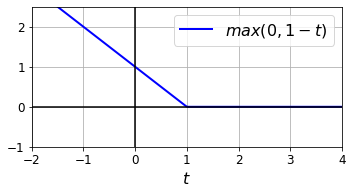

In [32]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

# Extra material

## Training time

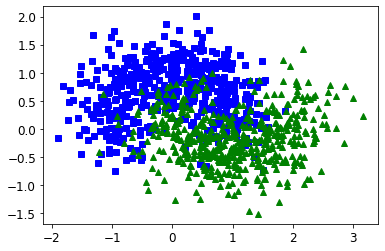

In [34]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.22378063201904297
[LibSVM]1 0.01 0.22394347190856934
[LibSVM]2 0.001 0.2648935317993164
[LibSVM]3 0.0001 0.4595818519592285
[LibSVM]4 1e-05 0.786088228225708
[LibSVM]5 1.0000000000000002e-06 0.7686920166015625
[LibSVM]6 1.0000000000000002e-07 5.382609844207764
[LibSVM]7 1.0000000000000002e-08 0.7274429798126221
[LibSVM]8 1.0000000000000003e-09 0.7256460189819336
[LibSVM]9 1.0000000000000003e-10 0.7317030429840088


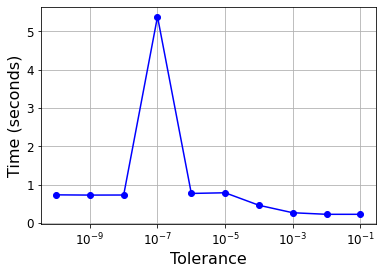

In [35]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## Linear SVM classifier implementation using Batch Gradient Descent

In [36]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [37]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

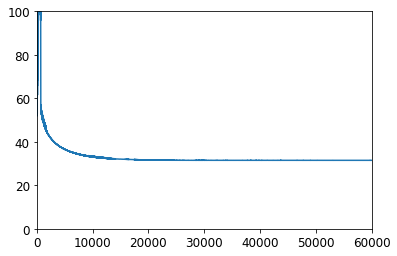

In [38]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [39]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [40]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

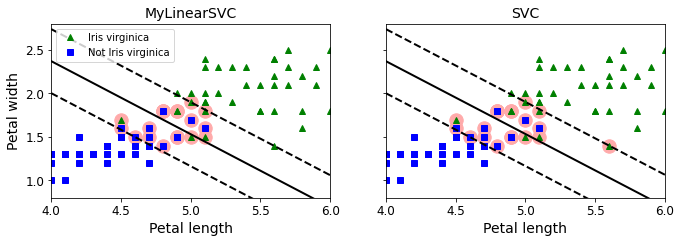

In [41]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

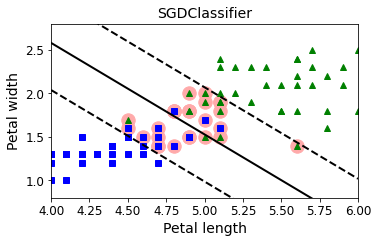

In [42]:
from sklearn.linear_model import SGDClassifier #导入SGD分类器

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])